## Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. \
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. \
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## План работы

1. Подготовить данные.
2. Провести исследовательский анализ данных.
3. Построить и обучить модель.

## Метрика качества 

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика sMAPE вычисляется так:
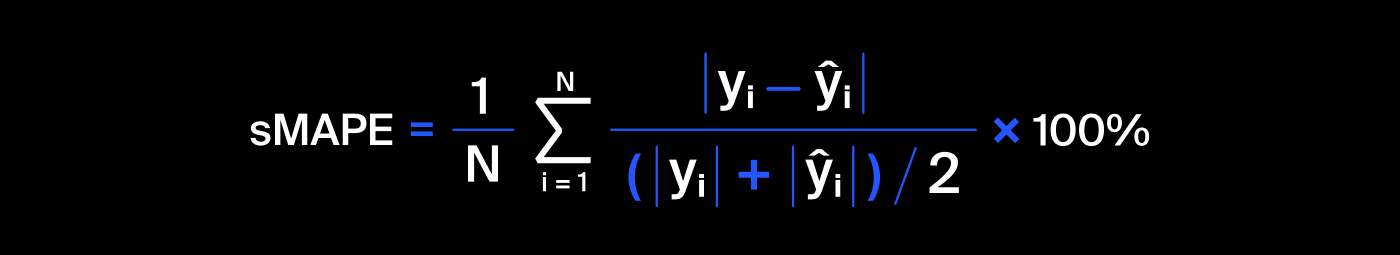
Нужно спрогнозировать сразу две величины:

эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:
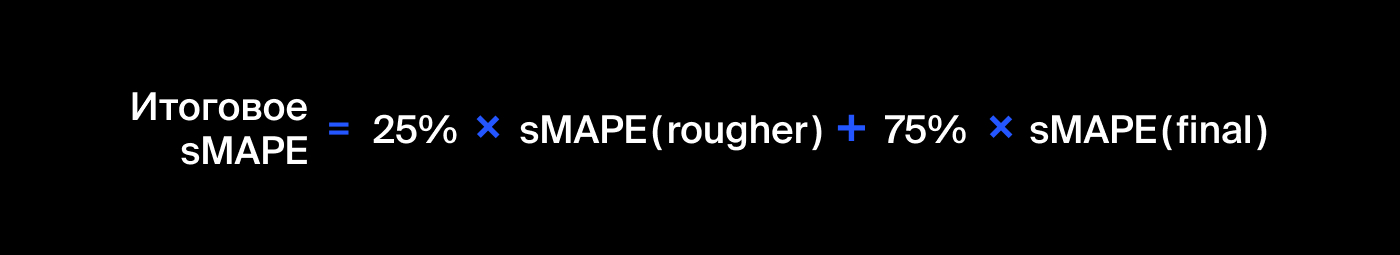

## 1.Предобработка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

print('OK')

OK


In [2]:
try:
    full = pd.read_csv(r'C:\Users\user\Desktop\Обучение\Data Science\Проекты ЯП по DS\08 Цифры\gold_recovery_full.csv')
    test = pd.read_csv(r'C:\Users\user\Desktop\Обучение\Data Science\Проекты ЯП по DS\08 Цифры\gold_recovery_test.csv')   
    train = pd.read_csv(r'C:\Users\user\Desktop\Обучение\Data Science\Проекты ЯП по DS\08 Цифры\gold_recovery_train.csv')
    
except:
    print('Ошибка загрузки')

In [3]:
# функция для вывода состава столбцов
def describe_cols(df_data):
    df = df_data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]
        
    return values.T.sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)


# функция для вывода пустых значений и их доли в столбцах датафрейма
def nan_values(df_data):
    df = df_data
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 1)
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df


# функция для вывода информации о файле
def df_info (df_data):
    print('Количество строк файла:', len(df_data))
    print()
    print('Информация о содержимом файла:')
    display(describe_cols(df_data))
    print()
    print('Информация о пропусках данных:')
    display(nan_values(df_data))
    print()
    print('Первые пять строк таблицы:')
    display(df_data.head())

# просмотр данных столбца: уникальные значения, тип данных, кол-во пропусков
def preprocessing(df, column):
    print('\nУНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА', column)
    #print(column, '-', dict_name[column])
    print('Тип данных', df[column].dtypes)
    print('Количество пропусков',df[column].isna().sum())
    print('Процент пропусков', round(df[column].isna().mean()*100, 2))
    if df[column].dtypes != 'object':
        print('Минимальное значение:',df[column].min(), 'Максимальное значение:', df[column].max())
    print('Уникальные значения:\n',df[column].value_counts(),'\n')

In [4]:
df_info(train)

Количество строк файла: 16860

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64,16860
rougher.state.floatbank10_e_level,"[-455.4629821777344, -450.8698476235493, -449....",float64,16806
rougher.state.floatbank10_e_air,"[1404.4720458984375, 1399.227083704032, 1399.1...",float64,16252
rougher.state.floatbank10_d_level,"[-451.2941284179688, -449.95364917032936, -449...",float64,16809
rougher.state.floatbank10_d_air,"[1598.937255859375, 1600.5275885762942, 1599.8...",float64,16799
...,...,...,...
primary_cleaner.state.floatbank8_b_air,"[1551.4342041015625, 1575.9506256801874, 1600....",float64,16168
primary_cleaner.state.floatbank8_a_level,"[-498.9121398925781, -500.9049649551747, -499....",float64,16826
rougher.calculation.floatbank10_sulfate_to_au_feed,"[3481.779052734375, 3498.3709791032525, 3495.3...",float64,16833
secondary_cleaner.state.floatbank6_a_level,"[-605.8419799804688, -599.7871842295434, -601....",float64,16758



Информация о пропусках данных:


,column_name,num_missing,percent_missing
Unnamed: 0,Unnamed: 0,0,0.0
date,date,0,0.0
final.output.concentrate_ag,final.output.concentrate_ag,72,0.4
final.output.concentrate_pb,final.output.concentrate_pb,72,0.4
final.output.concentrate_sol,final.output.concentrate_sol,370,2.2
...,...,...,...
secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_a_level,85,0.5
secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_air,85,0.5
secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank5_b_level,84,0.5
secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_air,103,0.6



Первые пять строк таблицы:


,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          16860 non-null  int64  
 1   date                                                16860 non-null  object 
 2   final.output.concentrate_ag                         16788 non-null  float64
 3   final.output.concentrate_pb                         16788 non-null  float64
 4   final.output.concentrate_sol                        16490 non-null  float64
 5   final.output.concentrate_au                         16789 non-null  float64
 6   final.output.recovery                               15339 non-null  float64
 7   final.output.tail_ag                                16794 non-null  float64
 8   final.output.tail_pb                                16677 non-null  float64


In [6]:
df_info(test)

Количество строк файла: 5856

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64,5856
rougher.state.floatbank10_c_level,"[-399.39672997149535, -399.630810078345, -401....",float64,5837
rougher.state.floatbank10_d_air,"[1198.287855098401, 1200.5064593644192, 1199.7...",float64,5839
rougher.state.floatbank10_d_level,"[-399.48859420055646, -399.9424338226521, -400...",float64,5840
rougher.state.floatbank10_e_air,"[999.4722502386644, 1000.0021142733016, 999.92...",float64,5839
rougher.state.floatbank10_e_level,"[-399.5309622422577, -399.49152776724816, -399...",float64,5840
rougher.state.floatbank10_f_air,"[949.566189353824, 950.2000089609317, 950.3204...",float64,5839
rougher.state.floatbank10_f_level,"[-398.1808065032195, -405.7875142628815, -400....",float64,5833
secondary_cleaner.state.floatbank2_a_air,"[24.93820004836713, 24.923465878892607, 24.908...",float64,5832
secondary_cleaner.state.floatbank2_a_level,"[-500.4909632087492, -499.8139628568625, -500....",float64,5840



Информация о пропусках данных:


,column_name,num_missing,percent_missing
Unnamed: 0,Unnamed: 0,0,0.0
date,date,0,0.0
primary_cleaner.input.sulfate,primary_cleaner.input.sulfate,302,5.2
primary_cleaner.input.depressant,primary_cleaner.input.depressant,284,4.8
primary_cleaner.input.feed_size,primary_cleaner.input.feed_size,0,0.0
primary_cleaner.input.xanthate,primary_cleaner.input.xanthate,166,2.8
primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_air,16,0.3
primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_a_level,16,0.3
primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_air,16,0.3
primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_b_level,16,0.3



Первые пять строк таблицы:


,Unnamed: 0,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  5856 non-null   int64  
 1   date                                        5856 non-null   object 
 2   primary_cleaner.input.sulfate               5554 non-null   float64
 3   primary_cleaner.input.depressant            5572 non-null   float64
 4   primary_cleaner.input.feed_size             5856 non-null   float64
 5   primary_cleaner.input.xanthate              5690 non-null   float64
 6   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 10  primary_clea

In [8]:
df_info(full)

Количество строк файла: 22716

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64,22716
rougher.state.floatbank10_e_level,"[-455.4629821777344, -450.8698476235493, -449....",float64,22646
rougher.state.floatbank10_e_air,"[1404.4720458984375, 1399.227083704032, 1399.1...",float64,22091
rougher.state.floatbank10_d_level,"[-451.2941284179688, -449.95364917032936, -449...",float64,22649
rougher.state.floatbank10_d_air,"[1598.937255859375, 1600.5275885762942, 1599.8...",float64,22638
...,...,...,...
primary_cleaner.state.floatbank8_b_air,"[1551.4342041015625, 1575.9506256801874, 1600....",float64,21856
primary_cleaner.state.floatbank8_a_level,"[-498.9121398925781, -500.9049649551747, -499....",float64,22665
rougher.calculation.floatbank10_sulfate_to_au_feed,"[3481.779052734375, 3498.3709791032525, 3495.3...",float64,22672
secondary_cleaner.state.floatbank6_a_level,"[-605.8419799804688, -599.7871842295434, -601....",float64,22598



Информация о пропусках данных:


,column_name,num_missing,percent_missing
Unnamed: 0,Unnamed: 0,0,0.0
date,date,0,0.0
final.output.concentrate_ag,final.output.concentrate_ag,89,0.4
final.output.concentrate_pb,final.output.concentrate_pb,87,0.4
final.output.concentrate_sol,final.output.concentrate_sol,385,1.7
...,...,...,...
secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_a_level,101,0.4
secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_air,101,0.4
secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank5_b_level,100,0.4
secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_air,119,0.5



Первые пять строк таблицы:


,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [9]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          22716 non-null  int64  
 1   date                                                22716 non-null  object 
 2   final.output.concentrate_ag                         22627 non-null  float64
 3   final.output.concentrate_pb                         22629 non-null  float64
 4   final.output.concentrate_sol                        22331 non-null  float64
 5   final.output.concentrate_au                         22630 non-null  float64
 6   final.output.recovery                               20753 non-null  float64
 7   final.output.tail_ag                                22633 non-null  float64
 8   final.output.tail_pb                                22516 non-null  float64


<b>Изучим уникальные значения и количество пропусков в процентах:

### train

In [10]:
for column in train.columns:
    preprocessing(train, column)


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Unnamed: 0
Тип данных int64
Количество пропусков 0
Процент пропусков 0.0
Минимальное значение: 0 Максимальное значение: 16859
Уникальные значения:
 0        1
11230    1
11232    1
11233    1
11234    1
        ..
5624     1
5625     1
5626     1
5627     1
16859    1
Name: Unnamed: 0, Length: 16860, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА date
Тип данных object
Количество пропусков 0
Процент пропусков 0.0
Уникальные значения:
 2016-01-15 00:00:00    1
2017-08-26 21:59:59    1
2017-08-26 23:59:59    1
2017-08-27 00:59:59    1
2017-08-27 01:59:59    1
                      ..
2017-01-05 07:59:59    1
2017-01-05 08:59:59    1
2017-01-05 09:59:59    1
2017-01-05 10:59:59    1
2018-08-18 10:59:59    1
Name: date, Length: 16860, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА final.output.concentrate_ag
Тип данных float64
Количество пропусков 72
Процент пропусков 0.43
Минимальное значение: 0.0 Максимальное значение: 16.001945119452092
Уникальные значения:
 0.000

Уникальные значения:
 0.000000e+00    365
2.631274e-18     90
4.131634e-18     51
4.595555e-17     39
2.016979e-16     36
               ... 
1.702690e+01      1
1.698212e+01      1
1.703095e+01      1
1.702579e+01      1
2.301862e+01      1
Name: secondary_cleaner.state.floatbank4_a_air, Length: 16099, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА secondary_cleaner.state.floatbank4_a_level
Тип данных float64
Количество пропусков 113
Процент пропусков 0.67
Минимальное значение: -799.9207129345235 Максимальное значение: -127.69233305288672
Уникальные значения:
 -799.638672    6
-799.700195    5
-795.533386    4
-799.668945    4
-799.667114    4
              ..
-499.847549    1
-500.225361    1
-500.227487    1
-499.700825    1
-500.492702    1
Name: secondary_cleaner.state.floatbank4_a_level, Length: 16728, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА secondary_cleaner.state.floatbank4_b_air
Тип данных float64
Количество пропусков 92
Процент пропусков 0.55
Минимальное значение: 0.0 Максим

### test

In [11]:
for column in test.columns:
    preprocessing(test, column)


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Unnamed: 0
Тип данных int64
Количество пропусков 0
Процент пропусков 0.0
Минимальное значение: 0 Максимальное значение: 5855
Уникальные значения:
 0       1
3911    1
3909    1
3908    1
3907    1
       ..
1950    1
1949    1
1948    1
1947    1
5855    1
Name: Unnamed: 0, Length: 5856, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА date
Тип данных object
Количество пропусков 0
Процент пропусков 0.0
Уникальные значения:
 2016-09-01 00:59:59    1
2017-10-11 23:59:59    1
2017-10-11 21:59:59    1
2017-10-11 20:59:59    1
2017-10-11 19:59:59    1
                      ..
2016-11-21 06:59:59    1
2016-11-21 05:59:59    1
2016-11-21 04:59:59    1
2016-11-21 03:59:59    1
2017-12-31 23:59:59    1
Name: date, Length: 5856, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА primary_cleaner.input.sulfate
Тип данных float64
Количество пропусков 302
Процент пропусков 5.16
Минимальное значение: 0.0001028054290833 Максимальное значение: 274.4096258580686
Уникальные значения:
 21

Уникальные значения:
 6.150709    1
5.901465    1
6.199937    1
6.201176    1
6.200002    1
           ..
5.898450    1
5.900642    1
5.900529    1
5.888351    1
7.201037    1
Name: rougher.input.floatbank11_xanthate, Length: 5503, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.state.floatbank10_a_air
Тип данных float64
Количество пропусков 17
Процент пропусков 0.29
Минимальное значение: -0.1231939685243493 Максимальное значение: 1423.2746866128366
Уникальные значения:
 1001.849317    1
1003.016741    1
1000.280801    1
999.830123     1
995.491510     1
              ..
998.188425     1
998.600329     1
999.401383     1
999.264366     1
1400.611544    1
Name: rougher.state.floatbank10_a_air, Length: 5839, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.state.floatbank10_a_level
Тип данных float64
Количество пропусков 16
Процент пропусков 0.27
Минимальное значение: -657.9497594243531 Максимальное значение: -273.776101238253
Уникальные значения:
 -350.301265    1
-299.988270    

### full

In [12]:
for column in full.columns:
    preprocessing(full, column)


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Unnamed: 0
Тип данных int64
Количество пропусков 0
Процент пропусков 0.0
Минимальное значение: 0 Максимальное значение: 22715
Уникальные значения:
 0        1
15173    1
15149    1
15148    1
15147    1
        ..
7570     1
7569     1
7568     1
7567     1
22715    1
Name: Unnamed: 0, Length: 22716, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА date
Тип данных object
Количество пропусков 0
Процент пропусков 0.0
Уникальные значения:
 2016-01-15 00:00:00    1
2017-10-08 04:59:59    1
2017-10-07 04:59:59    1
2017-10-07 03:59:59    1
2017-10-07 02:59:59    1
                      ..
2016-11-25 09:59:59    1
2016-11-25 08:59:59    1
2016-11-25 07:59:59    1
2016-11-25 06:59:59    1
2018-08-18 10:59:59    1
Name: date, Length: 22716, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА final.output.concentrate_ag
Тип данных float64
Количество пропусков 89
Процент пропусков 0.39
Минимальное значение: 0.0 Максимальное значение: 16.001945119452092
Уникальные значения:
 0.000

Уникальные значения:
 11.986616    1
16.990055    1
17.008563    1
17.010064    1
16.998755    1
            ..
14.000531    1
13.999993    1
13.998985    1
13.993632    1
6.146982     1
Name: rougher.input.floatbank10_sulfate, Length: 21415, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.input.floatbank10_xanthate
Тип данных float64
Количество пропусков 469
Процент пропусков 2.06
Минимальное значение: 2.8441252947292243e-06 Максимальное значение: 31.493331416036767
Уникальные значения:
 6.007990    1
6.200492    1
5.414275    1
5.598739    1
5.985798    1
           ..
6.500708    1
6.499229    1
6.499811    1
6.498864    1
9.308612    1
Name: rougher.input.floatbank10_xanthate, Length: 22247, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.input.floatbank11_sulfate
Тип данных float64
Количество пропусков 678
Процент пропусков 2.98
Минимальное значение: 1.4209480458512216e-05 Максимальное значение: 37.980647881026265
Уникальные значения:
 11.836743    1
17.000417    1
15.0007

Количество пропусков 67
Процент пропусков 0.29
Минимальное значение: -650.196203688203 Максимальное значение: -2.4060199662081687
Уникальные значения:
 -634.449463    4
-455.462982    1
-500.627854    1
-498.836327    1
-500.120864    1
              ..
-450.891892    1
-449.843481    1
-450.134853    1
-449.170805    1
-499.255503    1
Name: rougher.state.floatbank10_e_level, Length: 22646, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.state.floatbank10_f_air
Тип данных float64
Количество пропусков 75
Процент пропусков 0.33
Минимальное значение: -2.6361708230156875 Максимальное значение: 1950.49375093878
Уникальные значения:
 -2.164915       6
 1000.470872    1
 999.727319     1
 999.969949     1
 1000.825657    1
               ..
 900.708617     1
 900.332956     1
 901.024397     1
 899.803981     1
 850.112246     1
Name: rougher.state.floatbank10_f_air, Length: 22636, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА rougher.state.floatbank10_f_level
Тип данных float64
Количество

Уникальные значения:
 0.223880     5
0.298338     4
0.194259     2
0.187331     2
0.286225     2
            ..
21.992314    1
22.012949    1
22.021491    1
21.992545    1
19.990336    1
Name: secondary_cleaner.state.floatbank6_a_air, Length: 22587, dtype: int64 


УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА secondary_cleaner.state.floatbank6_a_level
Тип данных float64
Количество пропусков 101
Процент пропусков 0.44
Минимальное значение: -810.473526279162 Максимальное значение: -29.093593335314328
Уникальные значения:
 -763.892761    5
-809.723999    5
-531.443665    4
-809.822510    4
-799.923828    3
              ..
-500.876682    1
-499.829100    1
-500.160620    1
-500.513183    1
-499.191575    1
Name: secondary_cleaner.state.floatbank6_a_level, Length: 22598, dtype: int64 



In [13]:
train.columns

Index(['Unnamed: 0', 'date', 'final.output.concentrate_ag',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.concentrate_au', 'final.output.recovery',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',


<b>Рассчитаем эффективность обогащения чернового концентрата rougher.output.recovery из обучающей выборки. Предварительно удалим пропуски из столбцов со значением NaN.

In [14]:
train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                   'rougher.output.tail_au','rougher.output.recovery'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          14287 non-null  int64  
 1   date                                                14287 non-null  object 
 2   final.output.concentrate_ag                         14282 non-null  float64
 3   final.output.concentrate_pb                         14282 non-null  float64
 4   final.output.concentrate_sol                        14055 non-null  float64
 5   final.output.concentrate_au                         14283 non-null  float64
 6   final.output.recovery                               14149 non-null  float64
 7   final.output.tail_ag                                14287 non-null  float64
 8   final.output.tail_pb                                14173 non-null  float64


In [15]:
concentrate_au_column = train['rougher.output.concentrate_au']
feed_au_column = train['rougher.input.feed_au']
tail_au_column = train['rougher.output.tail_au']
input_recovery = train['rougher.output.recovery']
calculated_recovery = concentrate_au_column * (feed_au_column - tail_au_column) / feed_au_column / (concentrate_au_column - tail_au_column) * 100
print('Абсолютная средняя ошибка =', mean_absolute_error(input_recovery, calculated_recovery))

Абсолютная средняя ошибка = 1.0728296376685089e-14


MAE имеет очень малое отклонение - это значит, что расчетное значение rougher.output.recovery совпадает с данными из столбца.

Проведем чистку от пропущенных значений в обучающей и тестовой выборке.

In [16]:
good_train = train.dropna()
good_train.isna().mean()

Unnamed: 0                                    0.0
date                                          0.0
final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 88, dtype: float64

In [17]:
good_test = test.dropna()
good_test.isna().mean()

Unnamed: 0                                    0.0
date                                          0.0
primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0


In [18]:
good_train.columns

Index(['Unnamed: 0', 'date', 'final.output.concentrate_ag',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.concentrate_au', 'final.output.recovery',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',


В тестовой выборке отсуствуют столбцы этапов rougher.output, rougher.calculation, final.output, primary_cleaner.output и secondary_cleaner.output. Эти данные будут получены по результатам технологического процесса. Это онлайн метрики. Остальные столбцы исторически известны - значит это офлайн метрики.

Выделим столбцы из тестовой выборки, по которым будет обучаться модель. Столбец data не несет смысла для обучающей модели. Для предсказания rougher.output.recovery будут использоватся данные из стобцов этапа rougher. Для вычисления final.output.recovery будут использованы все столбцы из тестовой выборки.

In [19]:
features_columns = good_test.columns[2:]
print(features_columns,'\n')

rougher_features_columns = set(features_columns[13:34])
final_features_columns = set(features_columns)
print(rougher_features_columns)
print()
print(final_features_columns)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

<b> Пройдемся по ключевым столбцам в обучающей выборке.

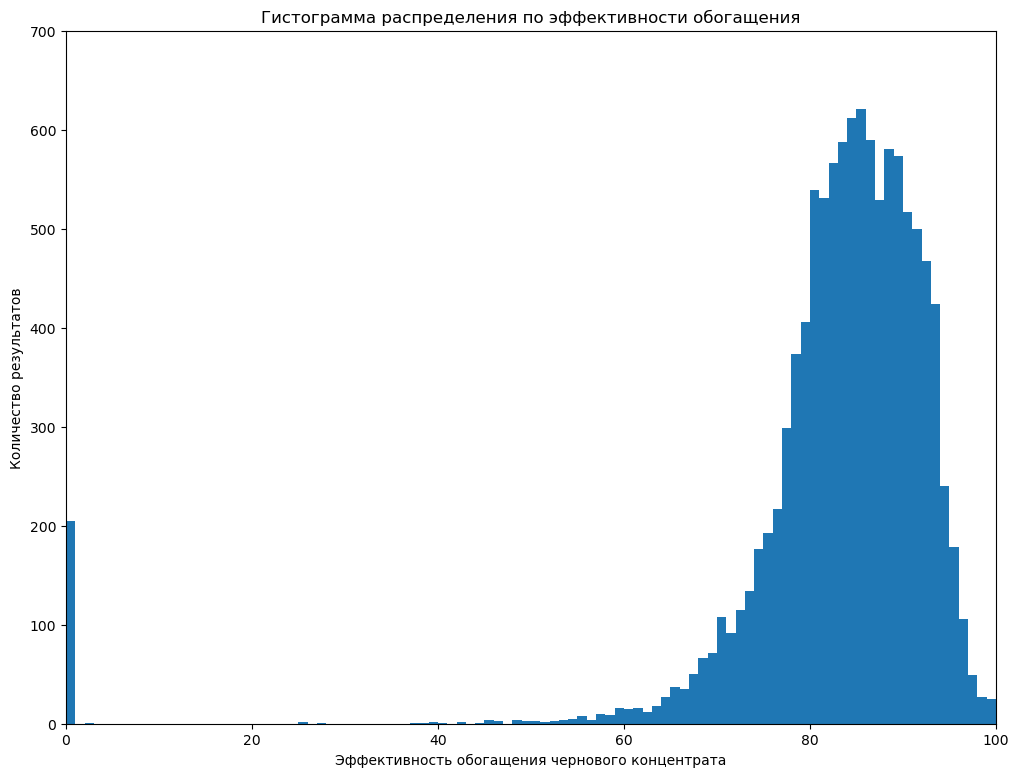

In [20]:
plt.figure(figsize=[12,9])

plt.hist(good_train['rougher.output.recovery'], bins=100)

plt.xlim([0, 100])
plt.ylim([0, 700])

plt.xlabel("Эффективность обогащения чернового концентрата")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

Изучим нулевые значения в столбце rougher.output.recovery:

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
good_train[good_train['rougher.output.recovery'] < 1].head()

,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.25,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,41359.061159,3196.130244,3205.717062,2.530283,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,0.0,0.0,0.0,0.0,4.784398,0.818965,20.046797,1.939811,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,13.605154,4.983564,9.545239,3.102137,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,141.184039,13.978607,7.25,1.248254,8.466262,9.780929,19

В данных нет информации о этапе rougher. Удалим эти значения, так как они могут исказить данные.

In [23]:
good_train = good_train.drop(good_train[good_train['rougher.output.recovery'] == 0].index)
good_train[good_train['rougher.output.recovery'] < 1].head()

,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


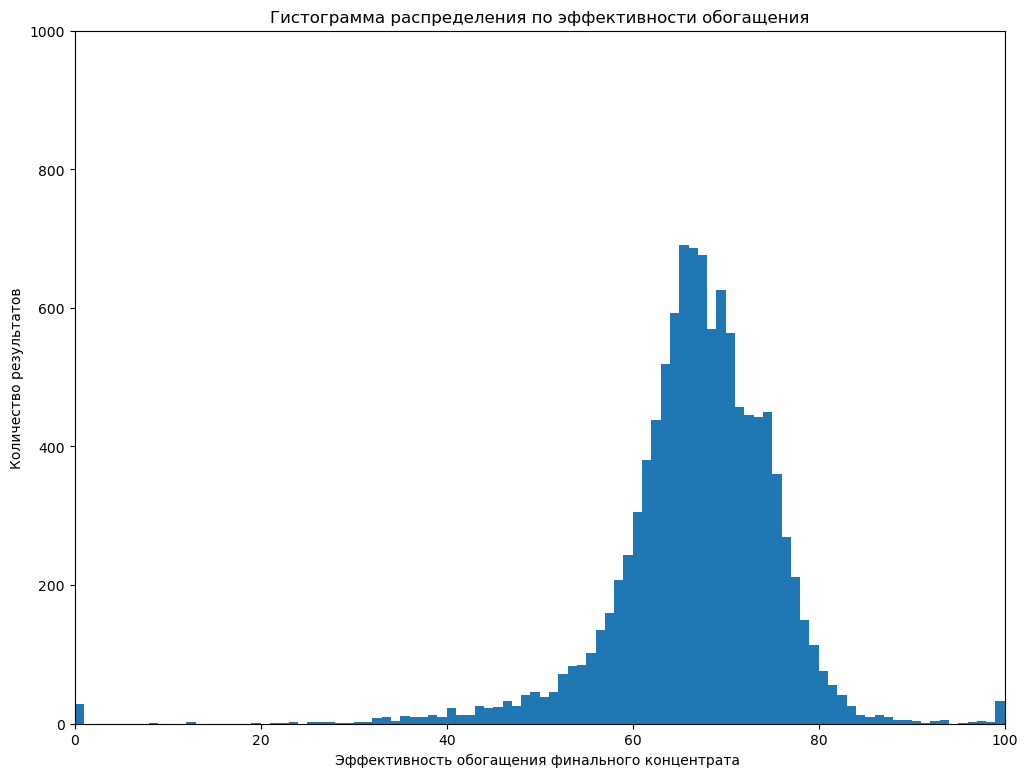

In [24]:
plt.figure(figsize=[12,9])

plt.hist(good_train['final.output.recovery'], bins=100)

plt.xlim([0, 100])
plt.ylim([0, 1000])

plt.xlabel("Эффективность обогащения финального концентрата ")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

In [25]:
good_train[good_train['final.output.recovery'] < 1].head()

,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
707,707,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,133.610147,14.032789,7.32,1.550190,8.986696,6.530607,11.969464,26.238846,13.854131,2.156414,8.174442,1.965728,1800.648807,-349.517991,1799.347332,-350.925554,1798.833149,-349.609813,1456.714168,-350.518404,45778.313924,2952.203313,2943.136954,2.894754,7.407737,1.934178,500.087438,51.965198,31.762853,5.598971,10.251319,6.620908,10.259054,6.620118,11.803589,7.143475,21.692525,15.935190,68.960993,5.114923,0.925673,20.699912,2.293607,999.884600,-499.972731,1499.290173,-399.546180,1499.161769,-398.630471,1499.040323,-399.389036,1501.877151,-397.227473,1501.061312,-400.602849,11.838086,3.905472,10.651508,2.283842,32.054894,-400.832639,30.998499,-401.051170,30.900779,-400.953348,29.003189,-401.031397,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808
1354,1354,2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,111.502432,11.927825,7.79,0.992436,8.701237,7.234158,10.754321,34.564456,13

In [26]:
good_train = good_train.drop(good_train[good_train['final.output.recovery'] == 0].index)
good_train[good_train['final.output.recovery'] < 1].head()

,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


In [27]:
good_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10784 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          10784 non-null  int64  
 1   date                                                10784 non-null  object 
 2   final.output.concentrate_ag                         10784 non-null  float64
 3   final.output.concentrate_pb                         10784 non-null  float64
 4   final.output.concentrate_sol                        10784 non-null  float64
 5   final.output.concentrate_au                         10784 non-null  float64
 6   final.output.recovery                               10784 non-null  float64
 7   final.output.tail_ag                                10784 non-null  float64
 8   final.output.tail_pb                                10784 non-null  float64


Проверим есть ли нулевые значения в primary_cleaner.output и secondary_cleaner.output.

In [28]:
good_train[good_train['primary_cleaner.output.concentrate_au'] < 1]['primary_cleaner.output.concentrate_au'].count()

109

In [29]:
good_train[good_train['secondary_cleaner.output.tail_au'] < 1]['secondary_cleaner.output.tail_au'].count()

426

По данным этапам тоже присутвуют нулевые значения. Но так как они не являются целью модели и не входят в список столбцов обучающей модели, оставим их без изменения.

<b>Вывод по шагу 1</b>

В данных присутвовали аномалии:

+ Пропущенные значение
+ Нулевые значения на ключевых этапах

Неподходящие данные были удалены. Возможно не были сняты данные по выбранным этапам или они еще не были получены в результате работы системы.

Данные готовы к дальнейшему анализу.

## 2.Анализ данных

<b> 2.1 Рассмотрим концентрацию веществ на каждом из этапов:

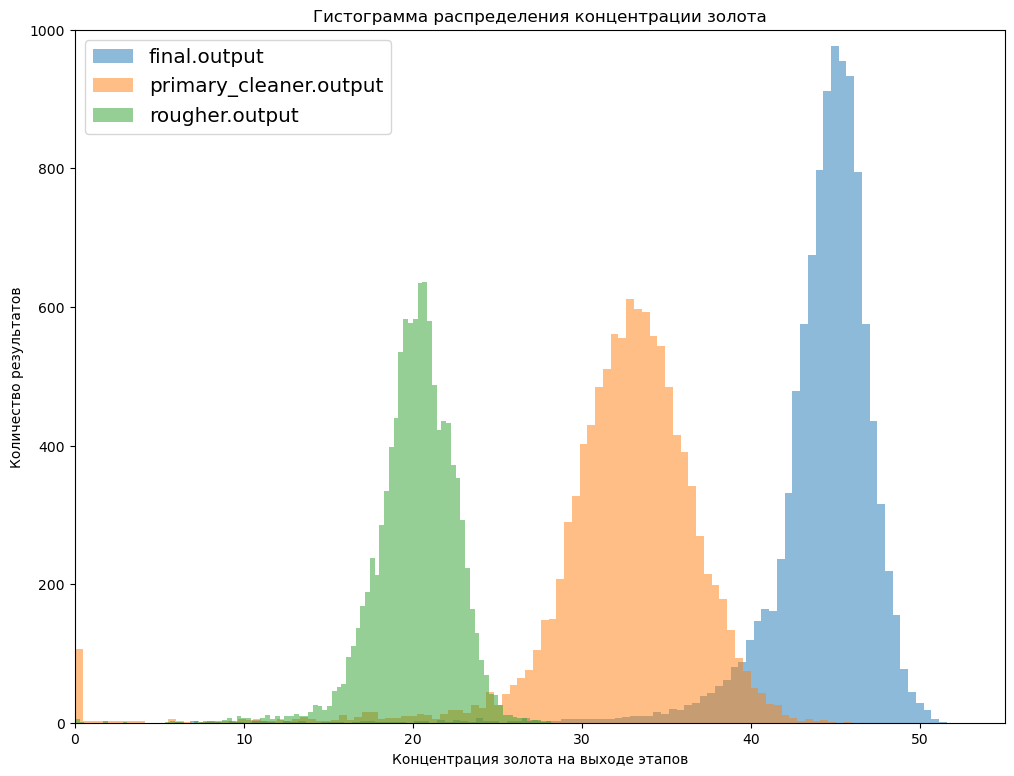

In [30]:
plt.figure(figsize=[12,9])

plt.hist(good_train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 55])
plt.ylim([0, 1000])

plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show()


Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.

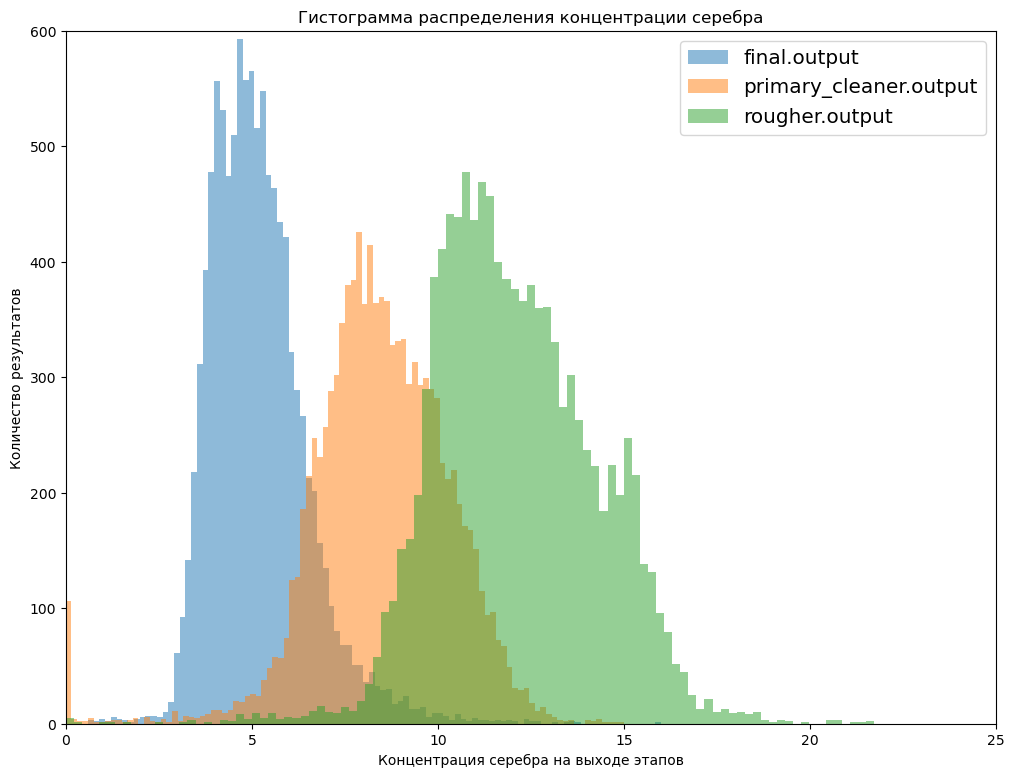

In [31]:
plt.figure(figsize=[12,9])

plt.hist(good_train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 25])
plt.ylim([0, 600])

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper right', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

Конецентрация серебра понижается с каждым шагом очистки. Так как основным благородным металом является золото, то остальные металлы и соединения должны быть отфильтрованы.

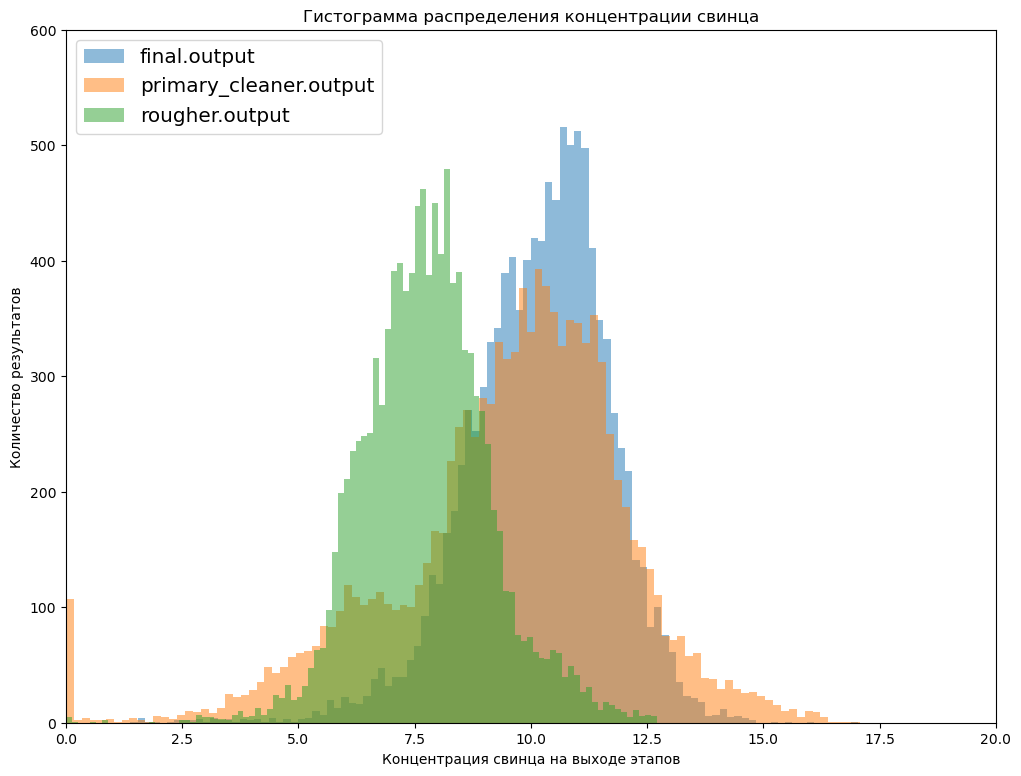

In [32]:
plt.figure(figsize=[12,9])

plt.hist(good_train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

Концентрация свинца повышается с этапа rougher до primary_cleaner. И потом усредняется. Это связано с химическим процесами очищения золота. При использование азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Повышение концентрации свинца в целом происходит не только из-за этого процесса, но из-за очищения других составляющих из золотоносной руды.

<b> 2.2 Изучим размеры сырья на этапах обработки.

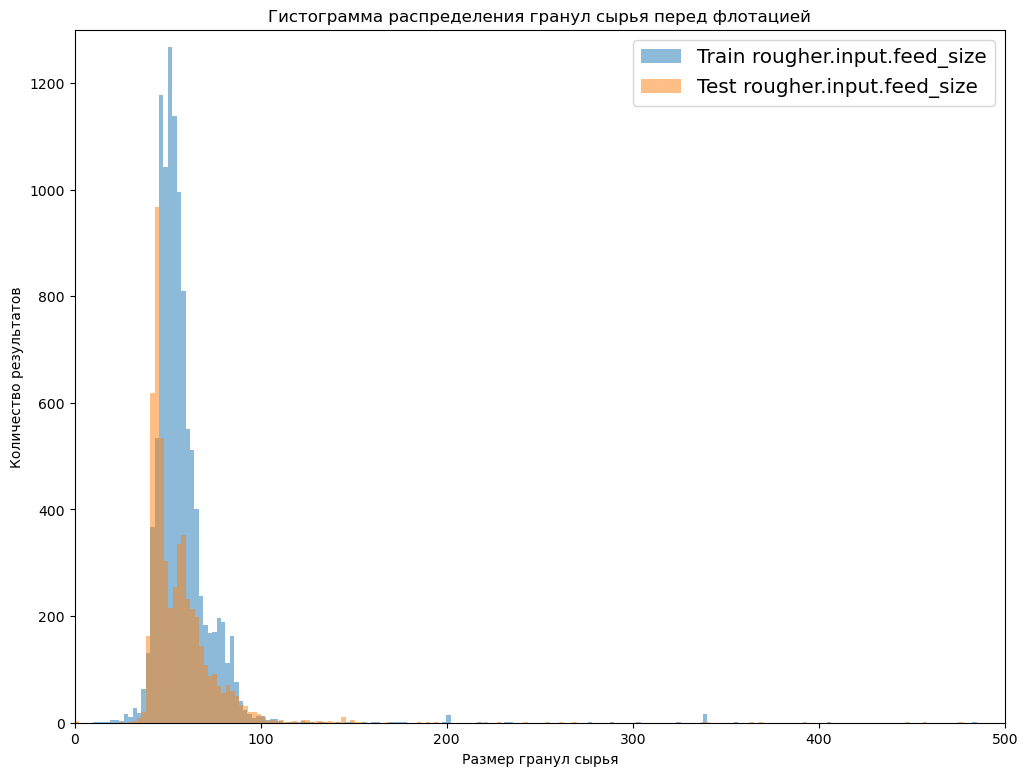

In [33]:
plt.figure(figsize=[12,9])

plt.hist(good_train['rougher.input.feed_size'], bins=200, label = 'Train rougher.input.feed_size', alpha=.5)
plt.hist(good_test['rougher.input.feed_size'], bins=200, label = 'Test rougher.input.feed_size', alpha=.5)

plt.xlim([0, 500])
plt.ylim([0, 1300])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc='upper right', fontsize='x-large')

plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

Распределение гранул до флотации похоже на нормальное со смещением влево как в обучающей, так и в тестовой выбрке. Существует много выбросов после размера гранул 100.

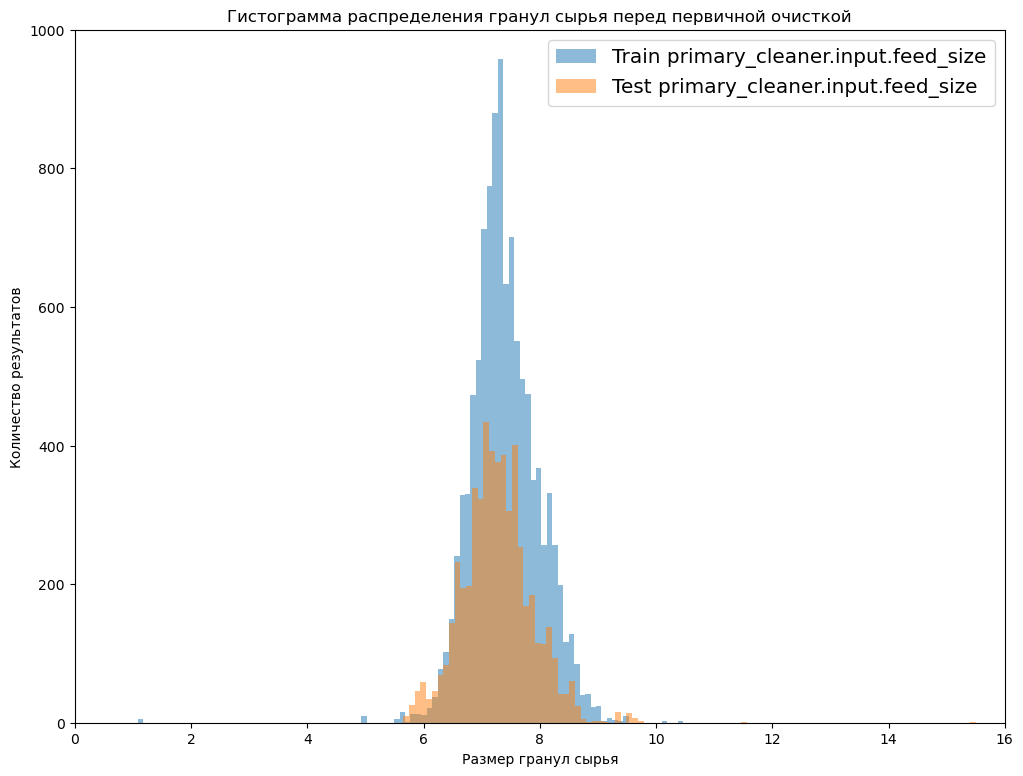

In [34]:
plt.figure(figsize=[12,9])

plt.hist(good_train['primary_cleaner.input.feed_size'], bins=100, label = 'Train primary_cleaner.input.feed_size', alpha=.5)
plt.hist(good_test['primary_cleaner.input.feed_size'], bins=100, label = 'Test primary_cleaner.input.feed_size', alpha=.5)

plt.xlim([0, 16])
plt.ylim([0, 1000])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc='upper right', fontsize='x-large')

plt.title("Гистограмма распределения гранул сырья перед первичной очисткой")
plt.show()

Размеры гранул перед первичной очисткой обладают нормальным распределением.

Подготовим столбцы с финальными концентрациями в обучающей выборке.

In [35]:
final_output_concentrate_sum_train = (good_train['final.output.concentrate_au'] + 
                                      good_train['final.output.concentrate_ag'] + 
                                      good_train['final.output.concentrate_pb'] +
                                      good_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum_train = (good_train['primary_cleaner.output.concentrate_au'] + 
                                                good_train['primary_cleaner.output.concentrate_ag'] + 
                                                good_train['primary_cleaner.output.concentrate_pb'] +
                                                good_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum_train = (good_train['rougher.output.concentrate_au'] + 
                                        good_train['rougher.output.concentrate_ag'] + 
                                        good_train['rougher.output.concentrate_pb'] +
                                        good_train['rougher.output.concentrate_sol'])

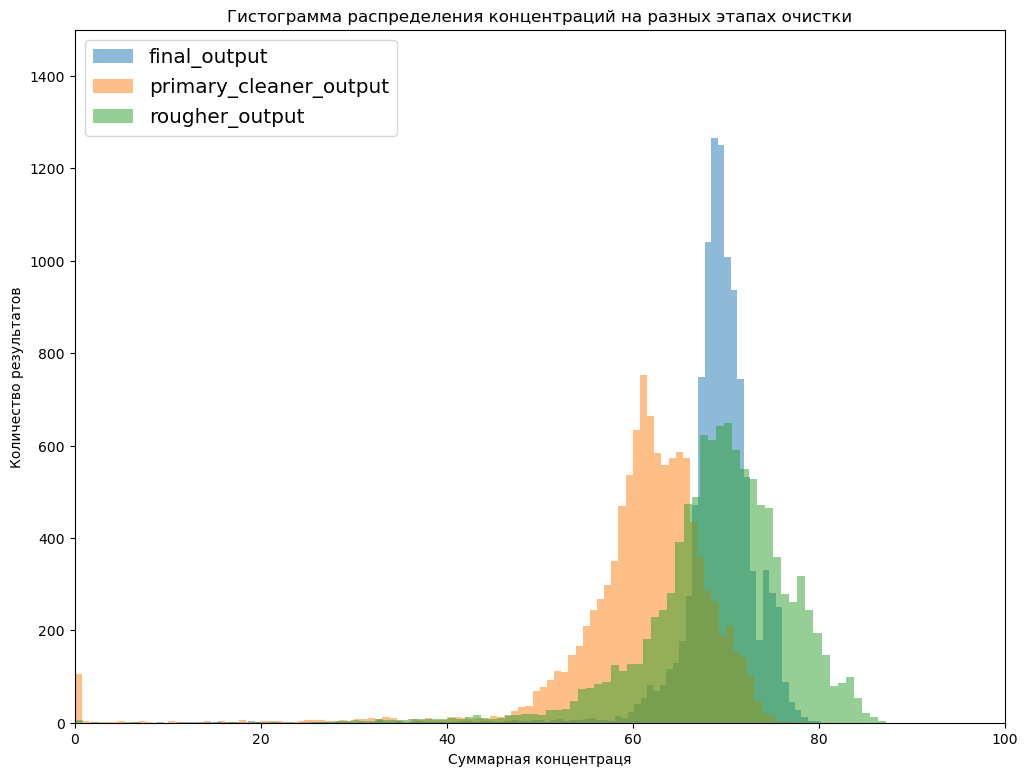

In [36]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

По графику видно, что из аномалий много значений в 0. Приблизим график.

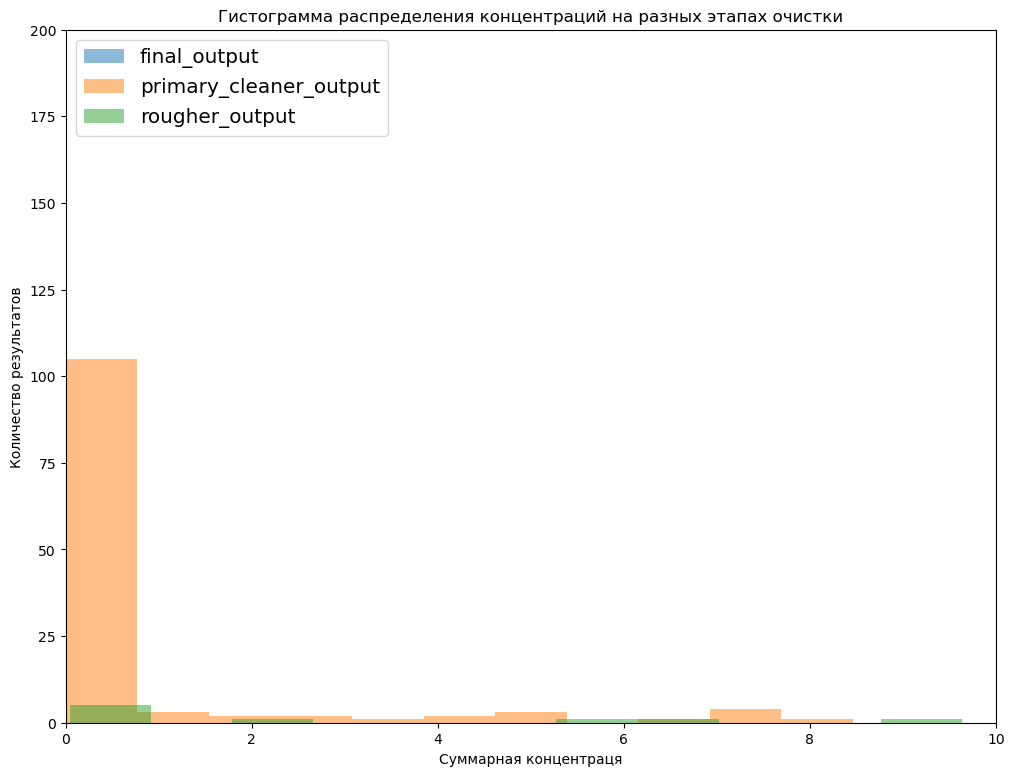

In [37]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 10])
plt.ylim([0, 200])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

На этапе предобрабоки были найдены строки с нулевыми значениями в primary_cleaner.output. Эти же строки показывают суммарную концентрацию, равную 0. Соответственно они являются аномалией. Удалим их.

In [38]:
good_train = good_train.drop(good_train[good_train['primary_cleaner.output.concentrate_au'] == 0].index)
good_train[good_train['primary_cleaner.output.concentrate_au'] == 0].head()

,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


<b>Вывод по разделу 2</b> 

В результате анализа были изучены:

+ Концетрации основных веществ на разных этапах очистки.
- Размер гранул тестовой и обучающей выборки.
* Суммарная концентрация веществ.

Аномалии были удалены. Данные готовы к обучению.

## 3.Модель

### 3.1 Создадим разделение признаков для предсказания rougher.output.recovery и final.output.recovery.

In [39]:
# Подготовка признаков для final.output.recovery
columns_to_delete = set(good_train.columns) - final_features_columns
print(columns_to_delete)
train_features_final = good_train.drop(columns_to_delete, axis=1)
print()
print(train_features_final.columns)
# Проверка вхождения всех столбцов из feateures в столбцах тестовой выборки
print(set(train_features_final.columns) - set(test.columns), 'look \n')

# Подготовка признаков для rougher.output.recovery
columns_to_delete = set(train_features_final.columns) - rougher_features_columns
print(columns_to_delete)
train_features_rougher = train_features_final.drop(columns_to_delete, axis=1)
print()
print(train_features_rougher.columns)

{'primary_cleaner.output.tail_pb', 'final.output.recovery', 'rougher.output.tail_sol', 'rougher.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_au', 'rougher.output.concentrate_au', 'Unnamed: 0', 'final.output.concentrate_sol', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.tail_sol', 'final.output.concentrate_ag', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.recovery', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_ag', 'final.output.tail_au', 'rougher.output.tail_ag', 'rougher.output.concentrate_sol', 'final.output.tail_ag', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail

<b>Подготовим целевой признак.

In [40]:
train_target_final = good_train['final.output.recovery']
train_target_rougher = good_train['rougher.output.recovery']

Подгоовим признаки тестовой выборки:

In [41]:
test_features = good_test.drop('date', axis=1)
test_features.columns

Index(['Unnamed: 0', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', '

In [42]:
test_features_final = test_features
columns_to_delete = set(test_features_final.columns) - rougher_features_columns
print(columns_to_delete)
test_features_rougher = test_features_final.drop(columns_to_delete, axis=1)

{'secondary_cleaner.state.floatbank3_a_air', 'rougher.input.feed_ag', 'secondary_cleaner.state.floatbank4_b_air', 'Unnamed: 0', 'secondary_cleaner.state.floatbank5_a_air', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank2_a_level', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank6_a_level', 'primary_cleaner.state.floatbank8_c_air', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank5_b_air', 'primary_cleaner.input.xanthate', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_a_air', 'primary_cleaner.input.feed_size', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.input.depressant', 'primary_cleaner.state.floatbank8_c_level', 'secondary_cleaner.state.floatbank6_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.f

### 3.2 Функция вычисления симметричного среднего абсолютного процентного отклонения.

In [43]:
def sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted):
    n = rougher_recovery_real.shape[0]
    rougher_sMAPE = ((2*abs(rougher_recovery_real - rougher_recovery_predicted)/
                     (abs(rougher_recovery_real) + abs(rougher_recovery_predicted))).sum() * 100 / n)
    final_sMAPE = ((2*abs(final_recovery_real - final_recovery_predicted)/
                     (abs(final_recovery_real) + abs(final_recovery_predicted))).sum() * 100 / n)
    return rougher_sMAPE * 0.25 + final_sMAPE * 0.75

<b>Перед нами стоит задача регресии. Выберем следующие модели для обучения:

+ Линейная регрессия
+ Полиноминальная регрессия. Применется на линейной регрессии с подготовленными признаками
+ Регрессия Ridge
+ DecisionTreeRegressor

Выполним поиск лучшей модели для предсказаний:

### 3.3.1 Линейная регрессия

In [44]:
%%time

regressor = LinearRegression()
print('Mean R2 from CV of LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of LinearRegression = -0.19455349428688598
Mean MAE from CV of LinearRegression = -5.903842205297205
Wall time: 122 ms


Проверим влияние масштаба признаков на качество модели.

In [45]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('Mean R2 from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of LinearRegression = -0.19455349428688712
Mean MAE from CV of LinearRegression = -5.9038422052972095
Wall time: 176 ms


Масштаб признаков на влияет.

### 3.3.2 Полиноминальная регрессия

In [46]:
regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
pipeline = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
print('Mean R2 from CV of PolynomialRegression with 2 degree =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of PolynomialRegression with 2 degree =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of PolynomialRegression with 2 degree = -53.89653182449943
Mean MAE from CV of PolynomialRegression with 2 degree = -31.7011974805681


<b>Для регрессоров Ridge и DecisionTreeRegressor применим метод GridSearchCV. В нем уже вложена кросс-валидация.

### 3.3.3 Линейная регрессияmm Ridge

In [47]:
%%time

regressor = Ridge()
hyperparams = [  {'alpha':[0.1, 1, 10, 100], 'solver':['auto']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['svd']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['cholesky']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['lsqr']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['sparse_cg']}]

scores = ['r2', 'neg_mean_absolute_error']

for score in scores:
    print('# Tuning hyper-parameters for %s' % score)
    print()
    clf = GridSearchCV(regressor, hyperparams, scoring=score)
    clf.fit(train_features_final, train_target_final)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'alpha': 100, 'solver': 'auto'}

Grid scores on development set:

-0.195 (+/-0.649) for {'alpha': 0.1, 'solver': 'auto'}
-0.194 (+/-0.649) for {'alpha': 1, 'solver': 'auto'}
-0.194 (+/-0.647) for {'alpha': 10, 'solver': 'auto'}
-0.187 (+/-0.628) for {'alpha': 100, 'solver': 'auto'}
-0.195 (+/-0.649) for {'alpha': 0.1, 'solver': 'svd'}
-0.194 (+/-0.649) for {'alpha': 1, 'solver': 'svd'}
-0.194 (+/-0.647) for {'alpha': 10, 'solver': 'svd'}
-0.187 (+/-0.628) for {'alpha': 100, 'solver': 'svd'}
-0.195 (+/-0.649) for {'alpha': 0.1, 'solver': 'cholesky'}
-0.194 (+/-0.649) for {'alpha': 1, 'solver': 'cholesky'}
-0.194 (+/-0.647) for {'alpha': 10, 'solver': 'cholesky'}
-0.187 (+/-0.628) for {'alpha': 100, 'solver': 'cholesky'}
-0.225 (+/-0.386) for {'alpha': 0.1, 'solver': 'lsqr'}
-0.225 (+/-0.386) for {'alpha': 1, 'solver': 'lsqr'}
-0.225 (+/-0.386) for {'alpha': 10, 'solver': 'lsqr'}
-0.224 (+/-0.386) for {'alp

### 3.3.4 DecisionTreeRegressor

In [48]:
max_depth_list = [x for x in range(2, 4, 2)]

In [49]:
print(max_depth_list)

[2]


In [50]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 4, 2)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[42]},
               {'criterion':['mae'], 'max_depth':max_depth_list, 'random_state':[42]}]


for x in max_depth_list:

    print('# Tuning hyper-parameters')
    print()
    clf = GridSearchCV(regressor, hyperparams)
    clf.fit(train_features_final, train_target_final)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()


# Tuning hyper-parameters

Best parameters set found on development set:

{'criterion': 'mae', 'max_depth': 2, 'random_state': 42}

Grid scores on development set:

-0.235 (+/-0.384) for {'criterion': 'mse', 'max_depth': 2, 'random_state': 42}
-0.030 (+/-0.238) for {'criterion': 'mae', 'max_depth': 2, 'random_state': 42}

Wall time: 58 s


### 3.4 Проверим лучшие модели по метрикам на созданной метрике sMAPE. Проверим реальные данные.

In [51]:
rougher_recovery_real = full.loc[test_features_rougher.index,'rougher.output.recovery']
final_recovery_real = full.loc[test_features_final.index,'final.output.recovery']
print('Процент пропусков в общей выборке' ,rougher_recovery_real.isna().mean())
print('Процент пропусков в общей выборке',final_recovery_real.isna().mean())

Процент пропусков в общей выборке 0.14397176295745867
Процент пропусков в общей выборке 0.10477428942968604


В реальной таблице отсутсвуют зачения для выборки. Они будут игнорироваться при расчете sMAPE.

In [55]:
%%time

test_features_final = test_features_final.drop('Unnamed: 0',axis=1)
model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для линейной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для полиноминальной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для регресии Ridge',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для DecisionTreeRegressor',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))  

sMAPE для линейной регресии 12.353135824702889
sMAPE для полиноминальной регресии 25.175341357992014
sMAPE для регресии Ridge 12.285720120513622
sMAPE для DecisionTreeRegressor 12.279099317448328
Wall time: 20.9 s


<b>Создадим константную модель на медианных значений. Изменим код функции для подсчета.

In [56]:
median_rougher_recovery = full['rougher.output.recovery'].median()
median_final_recovery = full['final.output.recovery'].median()

n = rougher_recovery_real.shape[0]
rougher_sMAPE = ((2*abs(rougher_recovery_real - median_rougher_recovery)/
                     (abs(rougher_recovery_real) + abs(median_rougher_recovery))).sum() * 100 / n)
final_sMAPE = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('sMAPE для медианной константной модели', rougher_sMAPE * 0.25 + final_sMAPE * 0.75)

sMAPE для медианной константной модели 11.437793816641223


<b>Проведем сокращение тестовой выборки из-за пропущенных значений rougher.output.recovery и final.output.recovery в полном датафрейме. Для вычисления sMAPE длина и индексы всех серий должны быть одинаковы.

In [57]:
rougher_recovery_real.dropna(inplace=True)
print('Количество строк rougher_recovery_real =', rougher_recovery_real.shape[0])
final_recovery_real.dropna(inplace=True)
print('Количество строк final_recovery_real =', final_recovery_real.shape[0])
print('Количество строк test_features_rougher =', test_features_rougher.shape[0])

not_nan_index = set(test_features_rougher.index)
not_nan_index = not_nan_index.intersection(set(final_recovery_real.index), set(rougher_recovery_real.index))
print('Количество индексов с полными данными=', len(not_nan_index))

Количество строк rougher_recovery_real = 4608
Количество строк final_recovery_real = 4819
Количество строк test_features_rougher = 5383
Количество индексов с полными данными= 4554


Преобразуем количество данных тестовой выбоки и рельных так, чтобы не было NaN.

In [58]:
rougher_recovery_real = full.loc[not_nan_index,'rougher.output.recovery']
final_recovery_real = full.loc[not_nan_index,'final.output.recovery']
test_features_rougher = test_features_rougher.loc[not_nan_index,:]
test_features_final = test_features_final.loc[not_nan_index,:]
print('Количество строк test_features_final =', test_features_final.shape[0])

Количество строк test_features_final = 4554


Повторим получение sMAPE на тех же моделях.

In [59]:
%%time

model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для линейной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для полиноминальной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для регресии Ridge',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для DecisionTreeRegressor',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted)) 

n = rougher_recovery_real.shape[0]
rougher_sMAPE = ((2*abs(rougher_recovery_real - median_rougher_recovery)/
                     (abs(rougher_recovery_real) + abs(median_rougher_recovery))).sum() * 100 / n)
final_sMAPE = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('sMAPE для медианной константной модели', rougher_sMAPE * 0.25 + final_sMAPE * 0.75)

sMAPE для линейной регресии 13.272654234672322
sMAPE для полиноминальной регресии 27.898078953388797
sMAPE для регресии Ridge 13.206027590991848
sMAPE для DecisionTreeRegressor 13.15461708751468
sMAPE для медианной константной модели 12.236756621839444
Wall time: 21 s


In [60]:
model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('R2 Ridge model =', r2_score(final_recovery_real, final_recovery_predicted))
print('MAE Ridge model =', mean_absolute_error(final_recovery_real, final_recovery_predicted))
print()

final_median_predict = pd.Series(median_final_recovery, index=not_nan_index)
print('R2 constant model =', r2_score(final_recovery_real, final_median_predict))
print('MAE constant model =', mean_absolute_error(final_recovery_real, final_median_predict))

R2 Ridge model = -0.3632440262747023
MAE Ridge model = 7.78405219641097

R2 constant model = -0.16953176961687788
MAE constant model = 6.986583173406041


<b>Вывод по шагу 3</b>

Была написана функция для вычисления sMAPE. Каждая модель была изучена на качество с помощью методов кросс-валидации и поиска гипер параметром GridSearchCV.

Была отобрана лучшая модель - Ridge. Ее значение sMAPE самое низкое.

После удаления значений NaN модель изменила свои значения. В полных данных отсутвует 14% и 10% данных по предсказаниям, возможно это повлияло на качество модели.

## Итоговый вывод
В ходе работы было выполнено:

1. Подготовлены данные.
2. Проведен исследовательский анализ данных.
3. Построена и обучена модель.

Основная сложность - скорость прохождения кросс-валидации с поиском лучших гиперпараметров.

Регрессор Ridge показал себя лучше обычной линейной регресии. sMAPE показал 12.27 до того как убрать пропущенные значения, и 13.19 после. Если сравнивать с константной моделью, значение проигрывает на 0.8 и 0.95 соответсвенно. Другие метрики тоже говорят о том, что константная модель адекватнее выбранной